Karen Gong

Partner: Harrison Robel

PHYS 434 AA Lab 2

In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [4]:
hf = h5py.File('gammaray_lab4.h5', 'r')
hf.keys()
data = np.array(hf.get('data'))
data[:,0]
hf.close()

Problem 1 

In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. The satellite takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. When it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

1. Download the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. 

Make a few plots, generally exploring your data and making sure you understand it. Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().

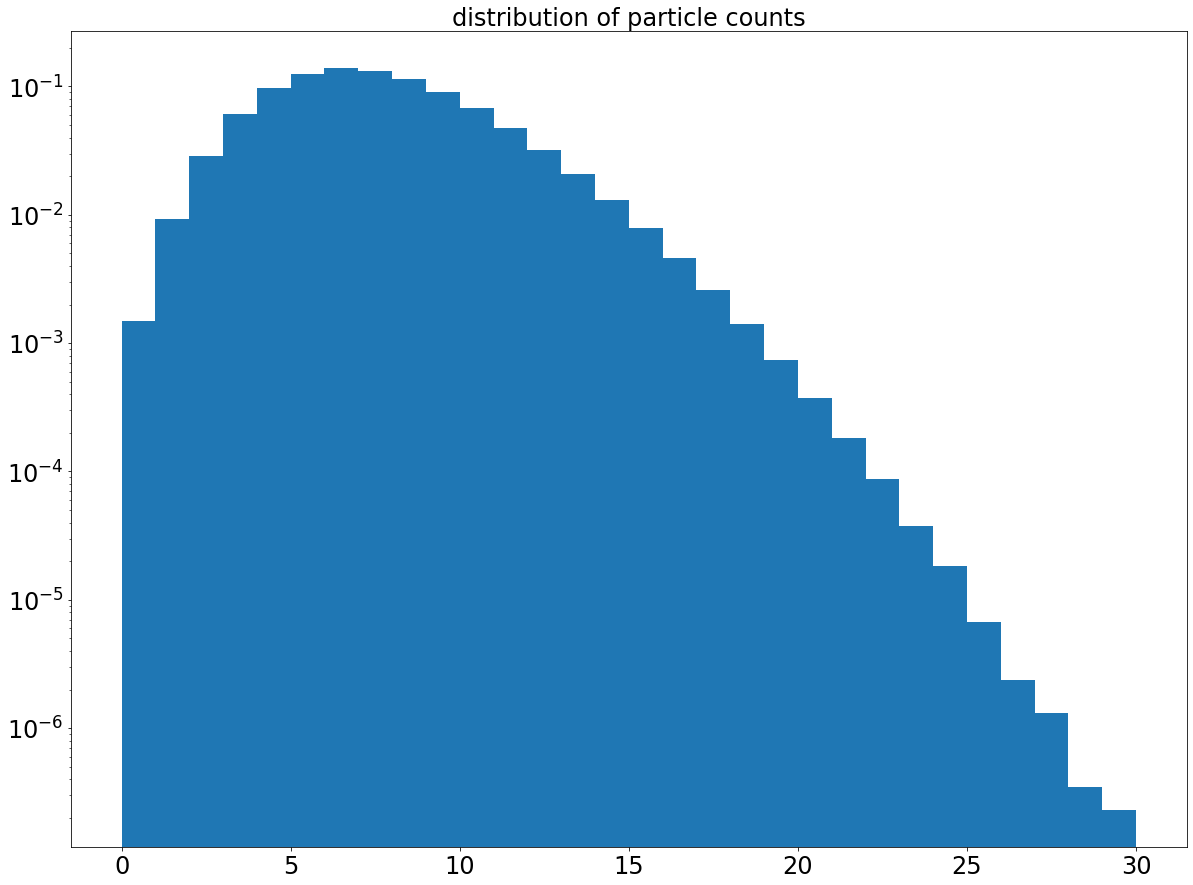

In [17]:
# COL 1: time (in gps seconds), COL 2: Solar phase (deg), COL 3: Earth longitude (deg), COL 4: gamma-ray counts

time = data[0,:]
solar = data[1,:]
longitude = data[2,:]
counts = data[3,:]

# distribution of particle counts
fig, ax = plt.subplots(1, 1)
ax.hist(counts,30, density=True)
plt.yscale("log")
plt.title("distribution of particle counts", size = 24)
plt.tick_params(labelsize = 24)
plt.show()

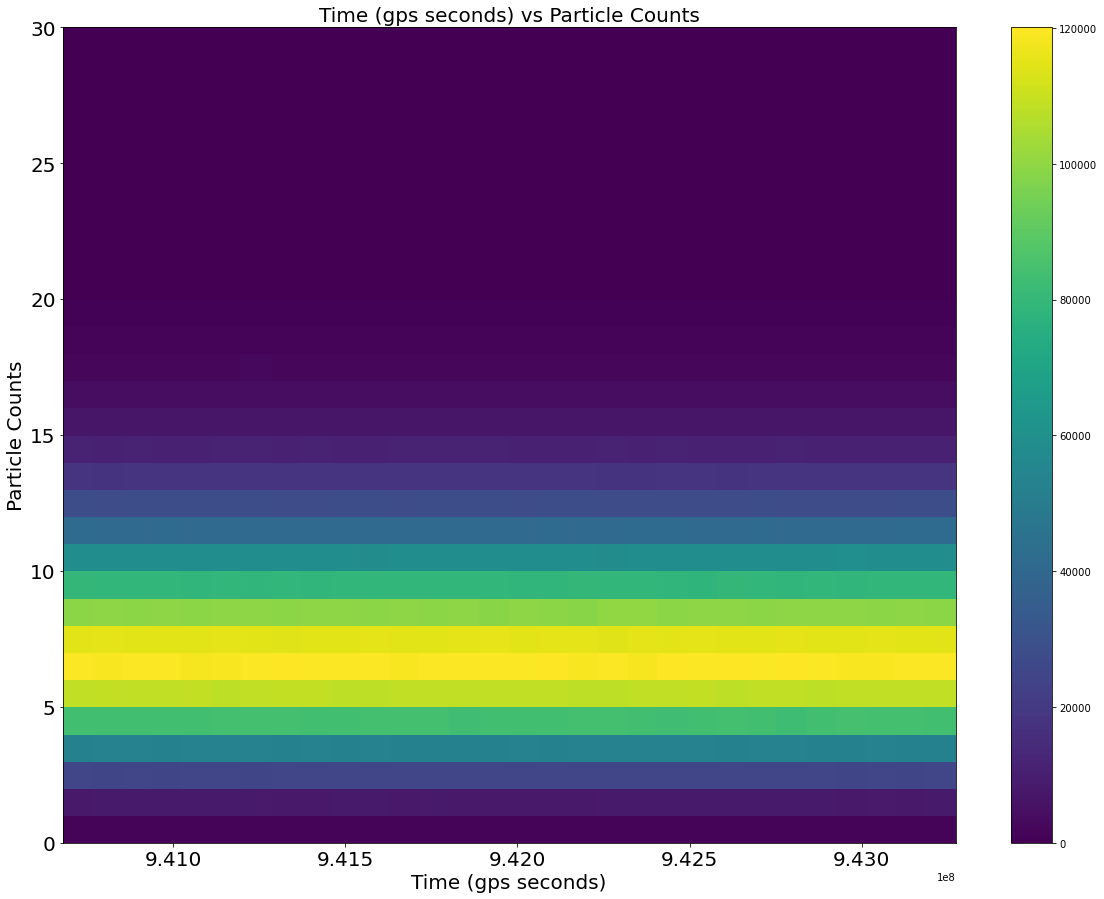

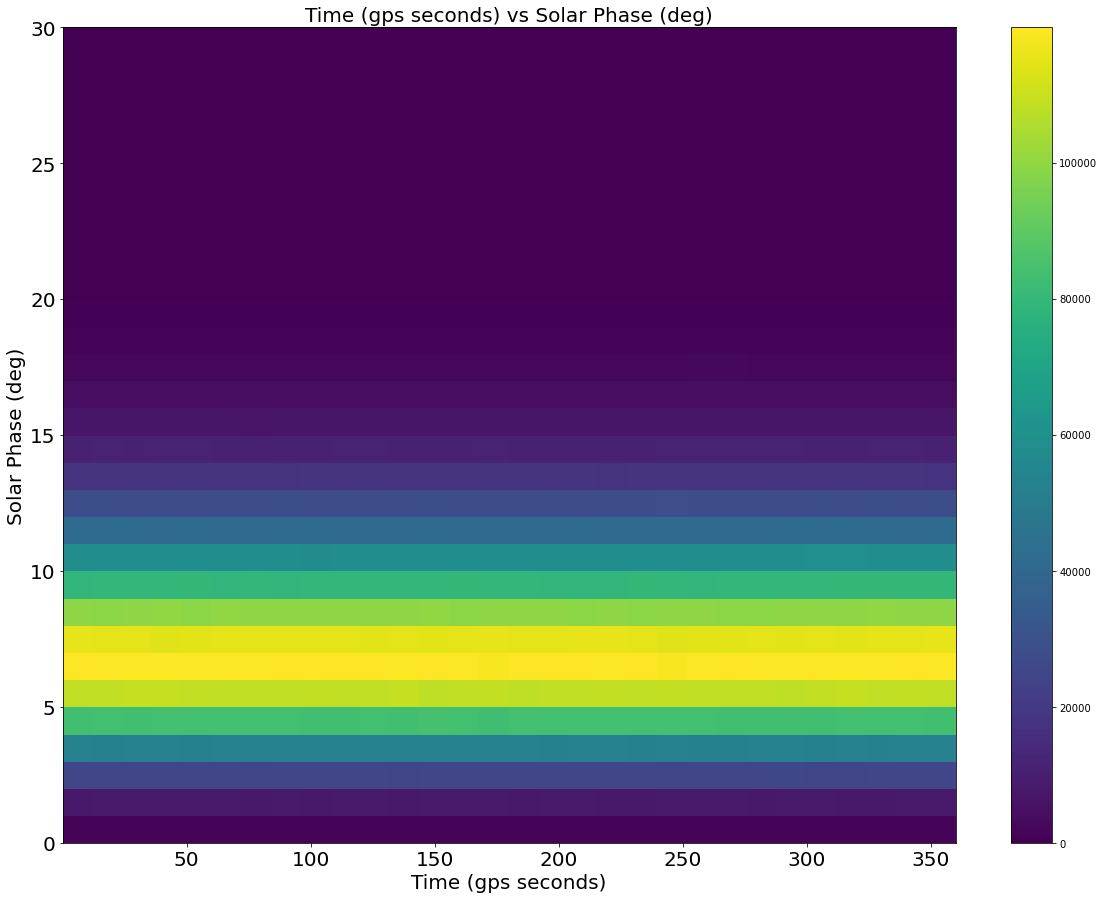

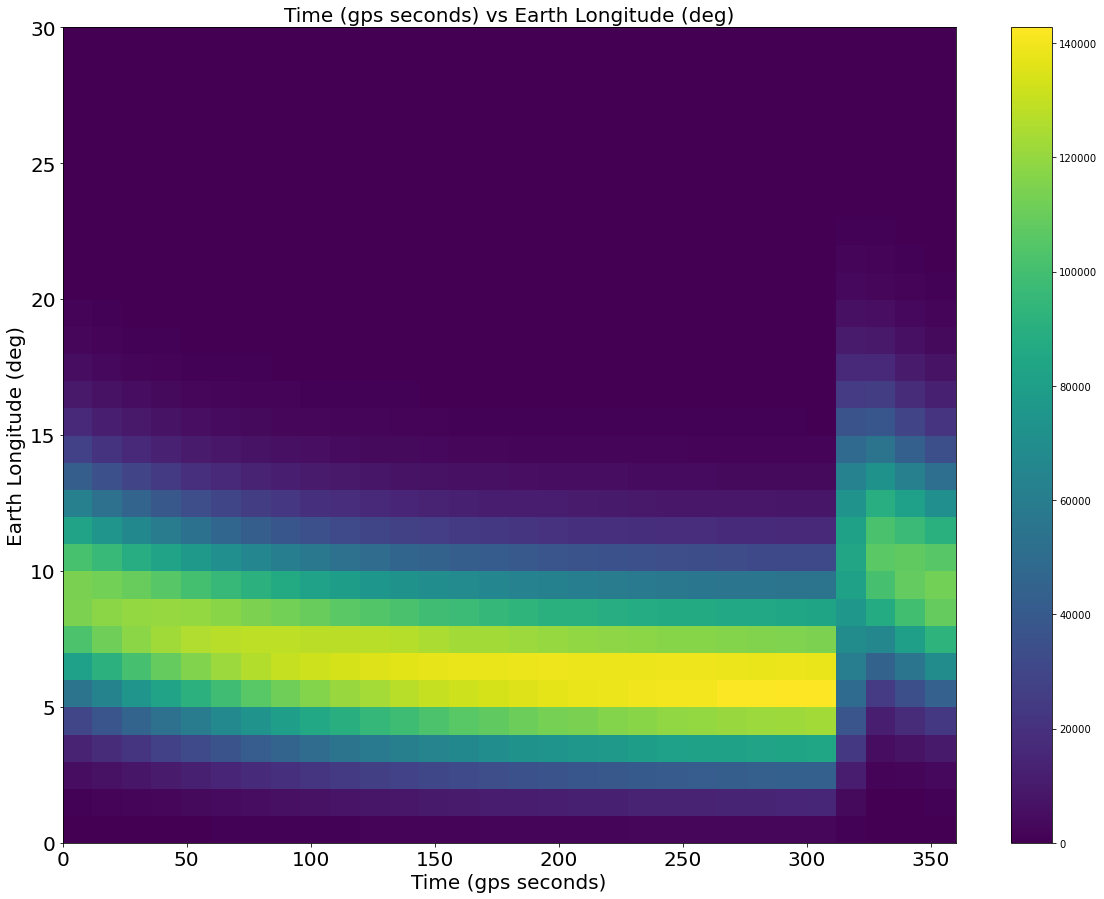

In [23]:
# this function plots the 2D histogram of two variables
def hist2d(x, y, ylabel):
    plt.hist2d(x, y, bins = 30)
    plt.tick_params(labelsize = 20)
    plt.xlabel("Time (gps seconds)", size = 20)
    plt.ylabel(ylabel, size = 20)
    plt.title("Time (gps seconds) vs " + ylabel, size = 20)
    plt.colorbar()
    plt.show()
    
hist2d(time, counts, "Particle Counts")
hist2d(solar, counts, "Solar Phase (deg)")
hist2d(longitude, counts, "Earth Longitude (deg)")

The particle counts distribution follows a Poisson distribution, as can be seen from the 1D histogram. This makes sense because the data counts are a discrete value so it should follow a discrete distribution. The following three graphs are 2D histograms of the three variables -- Solar phase, Earth longitude, and particle counts -- plotted against the time variable. The first two of the graphs, which are Particle Counts vs Time and Solar phase vs Time, respectively, do not seem to show any signs of signal contamination and they are constant with time. The final graph, which is Earth longitude vs Time, has an interesting effect. Firstly, unlike the other two 2D histograms, it's not constant as time goes on, it seems to follow some sort of decaying curve. This makes sense because it is the position of the spacecraft relative to the ground so it is continuously changing. Another interesting effect is that there is a jump in longitude, somewhere between 300 and 325 gps seconds. It is especially strange because it seems to be that if that piece was sliced and shifted to the beginning of the histogram (at 0 gps seconds), the entire 2D histogram would have no jumps and be smooth. The jump in the data could be due to the various reasons, such a mistake on the telescope's part or the rate at which the particles were measured changed or anything else. 

To make a background PDF to fix the inconsistencies in the data set, we can take slices of the Earth longitude vs particle count data, every 100 or so points. Then we can find the mean and standard deviation of those points to make a background distribution that limits the signal contamination.


3) 
particle count seems to be primarily dependent on longitude (with a secondary causation on time)


How background changes with longitude:
at one specific slice (at one instant of time) what do you expect to see

The first and last 60 degrees of Earth longitude there is some distortion

2. The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

The background is not consistent in the Earth longitude dataset. There is a periodic variation in time vs Earth longitude. The background seems to decay smoothly overall until about 310-320 gps seconds, where there is a sudden discontinuous jump in longitude. If the jump in longitude were moved to the beginning of the distribution, it would be a smooth distribution. 

3. Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

In [39]:
newtime = time[::100]
elong = longitude[::100]
mean = []

print(newtime, elong)
print(len(newtime))
print(len(elong))

#for i in newtime:
#    num = 

[9.40680016e+08 9.40680026e+08 9.40680036e+08 ... 9.43271996e+08
 9.43272006e+08 9.43272016e+08] [45.         45.66666667 46.33333333 ... 43.66666667 44.33333333
 45.        ]
259201
259201


4. Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

In [ ]:
#prob5sig = 1/3.5e6
prob5sig = stats.norm.cdf(5)

# 100 millisecond GRB
ms = 100

sigma1 = stats.poisson.ppf()

Problem 2 - look for something transient 

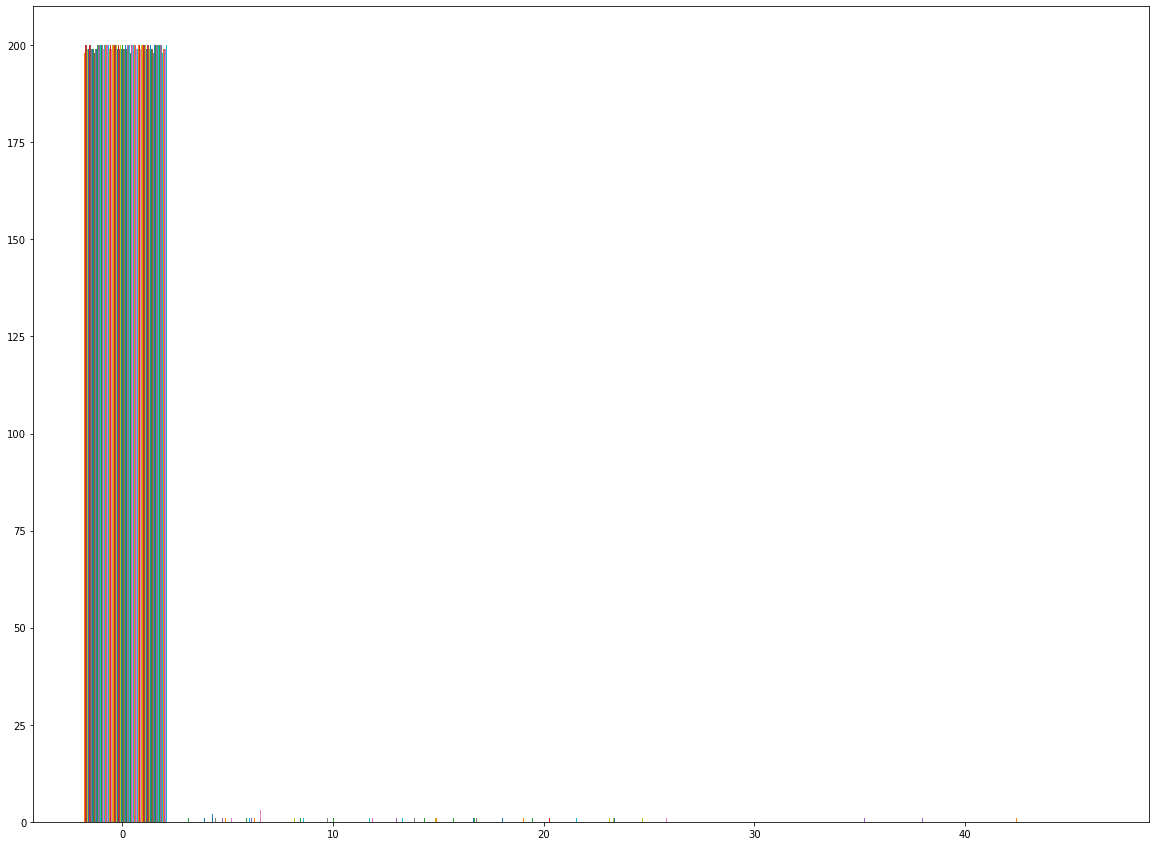

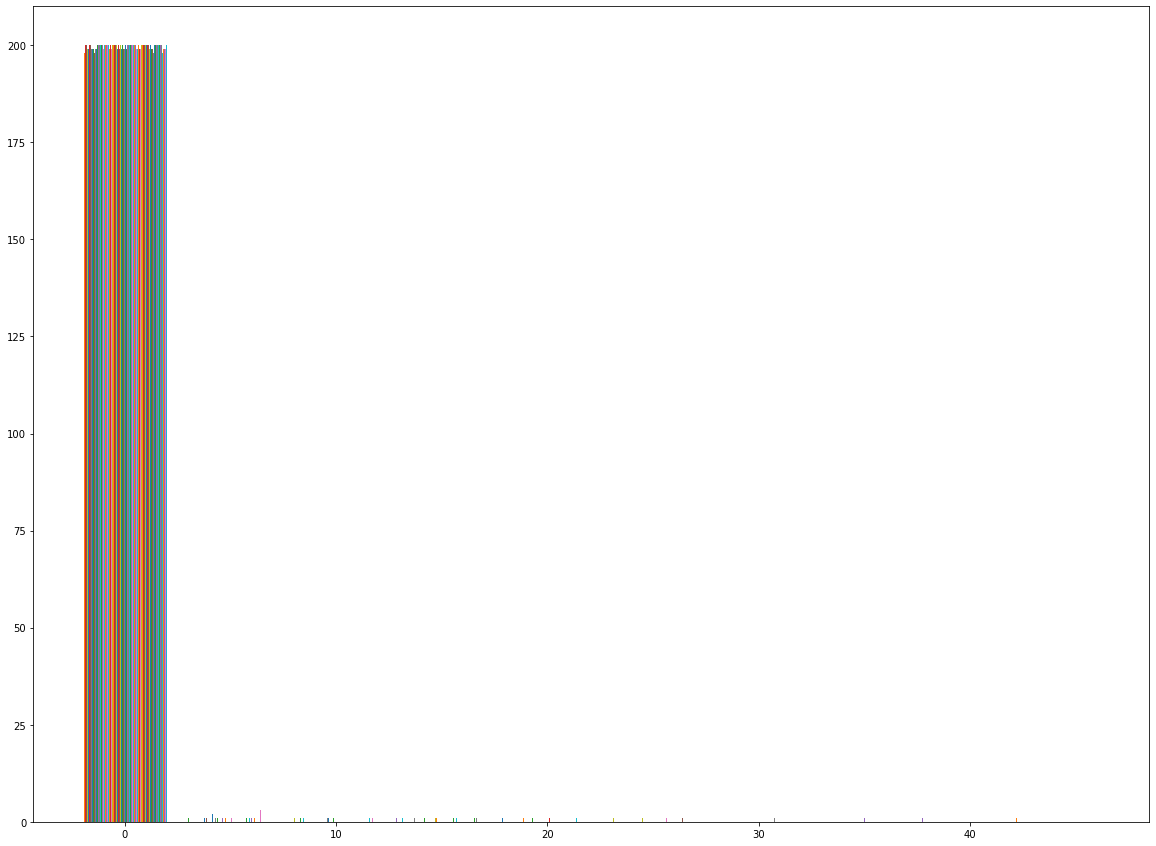

In [7]:
im = h5py.File('images.h5', 'r')
im.keys()
imimage = np.array(im.get('image1'))
imstack = np.array(im.get('imagestack'))
im.close()


# image 1
plt.hist(imimage)
plt.show()

plt.hist(imstack[:,:,1])
plt.show()

they are all stars, not technically part of background (so maybe can cut but there may be a better way to do it)
stars will be in the same location all the time

subtract the arrays to get the new array 

time-dependence: does the gaussian change shape over time
transient: looking at one image

plot an image given an array of brighteness values

plt.imshow()

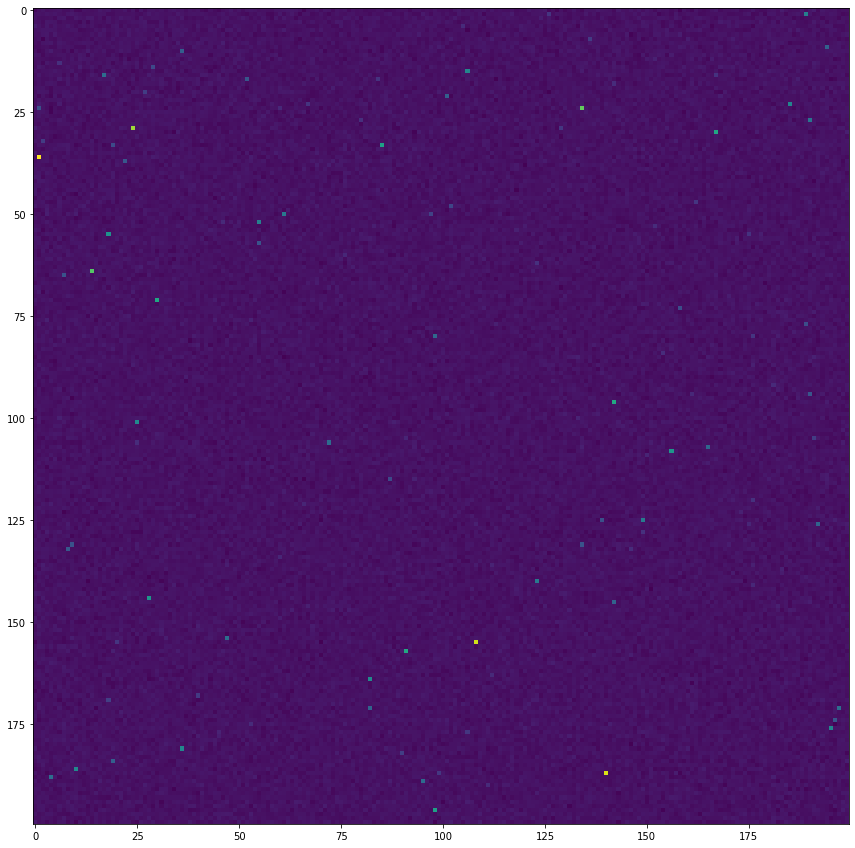

In [8]:
plt.imshow(imimage)